In [1]:
# first let's make sure you have internet enabled
import requests
requests.get('http://www.google.com',timeout=10).ok

True

In [2]:
%%capture
# ensure we are on the latest version of kaggle-environments
!pip install --upgrade kaggle-environments

In [3]:
# Now let's set up the chess environment!
from kaggle_environments import make
env = make("chess", debug=True)

No pygame installed, ignoring import



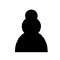
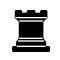
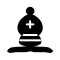
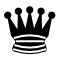
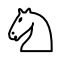
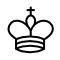
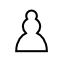
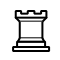
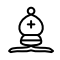
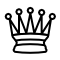
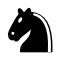
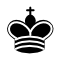

In [4]:
# this should run a game in the environment between two random bots
# NOTE: each game starts from a randomly selected opening
result = env.run(["random", "random"])
env.render(mode="ipython", width=1000, height=1000) 

In [5]:
%%writefile main.py
from Chessnut import Game
import random
import numpy as np
from collections import namedtuple, deque
import tensorflow as tf
from tensorflow.keras import layers

# Define the transition for learning
Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))

class DQNAgent:
    def __init__(self, state_size, action_size, learning_rate=0.001, gamma=0.95, epsilon=1.0, epsilon_min=0.1, epsilon_decay=0.995):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.learning_rate = learning_rate

        # Replay memory
        self.memory = deque(maxlen=2000)

        # Main and target networks
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.update_target_model()

    def _build_model(self):
        """
        Build a neural network for Q-value approximation.
        """
        model = tf.keras.Sequential([
            layers.Dense(64, activation='relu', input_dim=self.state_size),
            layers.Dense(64, activation='relu'),
            layers.Dense(self.action_size, activation='linear')  # Linear output for Q-values
        ])
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate), loss='mse')
        return model

    def update_target_model(self):
        """
        Update target model weights with main model weights.
        """
        self.target_model.set_weights(self.model.get_weights())

    def remember(self, state, action, reward, next_state, done):
        """
        Store a transition in replay memory.
        """
        self.memory.append(Transition(state, action, reward, next_state, done))

    def choose_action(self, obs, moves):
        """
        Choose an action using epsilon-greedy policy.
        """
        if np.random.rand() <= self.epsilon:
            # Explore: choose a random move
            return random.choice(moves)

        # Exploit: predict Q-values for each move
        state = self._encode_state(obs.board)
        q_values = self.model.predict(state, verbose=0)
        best_action_idx = np.argmax(q_values)
        return moves[best_action_idx]

    def _encode_state(self, board):
        """
        Encode the board (FEN string) as a numerical state vector.
        This is a placeholder; implement specific encoding for chess.
        """
        # Example: Convert FEN to a simple one-hot encoding (needs detailed implementation)
        state_vector = np.zeros((1, self.state_size))
        # Populate `state_vector` based on the FEN
        return state_vector

    def replay(self, batch_size):
        """
        Train the model using a random sample from the replay memory.
        """
        if len(self.memory) < batch_size:
            return

        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = self.model.predict(state, verbose=0)
            if done:
                target[0][action] = reward
            else:
                next_q_values = self.target_model.predict(next_state, verbose=0)
                target[0][action] = reward + self.gamma * np.amax(next_q_values)

            # Train the model
            self.model.fit(state, target, epochs=1, verbose=0)

        # Decay epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

def train_agent(env, episodes=20, batch_size=32):
    """
    Train the DQN agent for a specified number of episodes.
    """
    # Define hyperparameters and initialize agent
    state_size = 64  # Placeholder for board representation size
    action_size = 4672  # Placeholder for maximum legal moves (adjust as needed)
    agent = DQNAgent(state_size, action_size)

    for episode in range(episodes):
        print(f"Episode {episode + 1}/{episodes}")
        obs = env.reset()
        done = False

        while not done:
            game = Game(obs.board)
            moves = list(game.get_moves())

            if not moves:
                break

            # Agent selects action
            action = agent.choose_action(obs, moves)

            # Execute the action in the environment
            next_obs, reward, done, _ = env.step(action)

            # Encode state and next_state
            state = agent._encode_state(obs.board)
            next_state = agent._encode_state(next_obs.board)

            # Remember transition
            agent.remember(state, action, reward, next_state, done)

            # Train the agent
            agent.replay(batch_size)

            # Move to the next state
            obs = next_obs

        # Update target network
        agent.update_target_model()

    return agent

def chess_bot(obs):
    """
    Chess bot that uses a trained DQN agent to make moves.
    """
    # Placeholder state size and action size
    state_size = 64
    action_size = 4672

    # Load or initialize the agent
    agent = DQNAgent(state_size, action_size)

    # Get legal moves
    game = Game(obs.board)
    moves = list(game.get_moves())

    # Choose an action
    return agent.choose_action(obs, moves)

# Train the agent
# Ensure `env` is a compatible environment object
# env should be initialized externally (e.g., using a specific chess environment)


Writing main.py


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Timeout: 
Agent exit status/reward/time left: 
	 TIMEOUT / None / -3.4450660000000006
	 DONE / 0 / 10





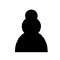
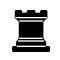
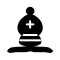
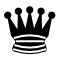
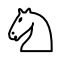
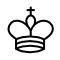
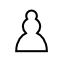
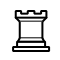
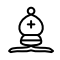
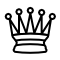
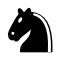
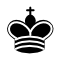

In [6]:
result = env.run(["main.py", "random"])
print("Agent exit status/reward/time left: ")
# look at the generated replay.json and print out the agent info
for agent in result[-1]:
    print("\t", agent.status, "/", agent.reward, "/", agent.observation.remainingOverageTime)
print("\n")
# render the game
env.render(mode="ipython", width=1000, height=1000) 

### Testing your agent

Now let's see how your agent does againt the random agent!

# To Submit:
1. Download (or save) main.py
2. Go to the [submissions page](https://www.kaggle.com/competitions/fide-google-efficiency-chess-ai-challenge/submissions) and click "Submit Agent"
3. Upload main.py
4. Press Submit!

Now doubt you are already thinking of ways this bot could be improved! Go ahead and fork this notebook and get started! ♟️

# Submitting Multiple files 
### (or compressing your main.py)

Set up your directory structure like this:
```
kaggle_submissions/
  main.py
  <other files as desired>
```

You can run `tar -czf submission.tar.gz -C kaggle_submissions .` and upload `submission.tar.gz`